In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
from autocorrect import Speller
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

## Import the Data

In [2]:
df = pd.read_csv('Data/final_data.csv', header=None)
# df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
# Printing unique category
df[1].unique()

array(['positive', 'imperative', 'interrogative', 'miscellaneous',
       'corrective', 'negative'], dtype=object)

In [4]:
# removing duplicate rows
# df = df.drop_duplicates()
df.duplicated().any()

True

In [5]:
# Checking null values
df.isnull().sum()

0    0
1    0
dtype: int64

In [6]:
# Checking the shape of the data
df.shape

(1716, 2)

## Preprocessing

In [7]:
# Preprocessing

# lowercasing
df[0] = df[0].str.lower()

# removing urls
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df[0] = df[0].str.replace('\n',' ', regex=True)

# removing all the punctuations
df[0] = df[0].str.replace('[^\w\s]',' ')

# removing integers
df[0] = df[0].str.replace('\d','', regex=True)

# removing emojis
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)
df

<ipython-input-7-fcb4b1ba984c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)
<ipython-input-7-fcb4b1ba984c>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s]',' ')
<ipython-input-7-fcb4b1ba984c>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)


,0,1
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,miscellaneous
...,...,...
1711,thanks very much for taking the time to put up...,positive
1712,i have installed java but why jre folder not s...,imperative
1713,i dont see the jre file below the jdk did i do...,interrogative
1714,turn up your microphone,imperative


In [8]:
# df.rename(columns={'comment':0, 'category':1}, inplace=True)
# df

In [9]:
# correcting the typos

spell = Speller(lang='en')

def typo_corrector(text):
    return spell(text)

df[0] = df[0].apply(typo_corrector)
df[0]

0                                          love you sir  
1       please make videos on  midpoint circle drawing...
2       i bought both of your courses on dmy  you are ...
3       thank you very much  u really got me in the fi...
4       i hope u are ok with everything going on again...
                              ...                        
1711    thanks very much for taking the time to put up...
1712    i have installed java but why are folder not s...
1713    i dont see the are file below the jk did i do ...
1714                         turn up your microphone     
1715             how to know in window  java is installed
Name: 0, Length: 1716, dtype: object

In [10]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df[0] = df[0].apply(lemmatize_text)
df

# # # stemming
# stemmer = nltk.stem.SnowballStemmer('english')
# def stem_text(text):
#     return stemmer.stem(text)

# df[0] = df[0].apply(stem_text)
# df

# lemmatizing

# nltk.download('wordnet')



,0,1
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on dmy you are ...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,miscellaneous
...,...,...
1711,thanks very much for taking the time to put up...,positive
1712,i have installed java but why are folder not s...,imperative
1713,i dont see the are file below the jk did i do ...,interrogative
1714,turn up your microphone,imperative


In [11]:
# Removing stopwords
# nltk.download('stopwords')

stop = stopwords.words('english')

# These are the words that should not be removed from their category
negative_words = ['no','not']
interrogative_words = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am',
                      'are','could','would','should','can','did','does','do','had','have']
imperative_words = ['could','would','should','can']

for_negative_category = stop.copy()
for word in negative_words:
    if word in for_negative_category:
        for_negative_category.remove(word)
    
for_interrogative_category = stop.copy()
for word in interrogative_words:
    if word in for_interrogative_category:
        for_interrogative_category.remove(word)
    
for_imperative_category = stop.copy()
for word in imperative_words:
    if word in for_imperative_category:
        for_imperative_category.remove(word)

# For negative category
for i in range(len(df)):
    if df[1][i] == "negative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_negative_category])

# For interrogative category
for i in range(len(df)):
    if df[1][i] == "interrogative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_interrogative_category])
        
# For interrogative category
for i in range(len(df)):
    if df[1][i] == "imperative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_imperative_category])
        
# For all other category
for i in range(len(df)):
    if df[1][i] == "positive" or df[1][i] == "correction" or df[1][i] == "other":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in stop])

# df[0] = df[0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df

In [13]:
# from wordcloud import WordCloud
# text = df[0].values 

# wordcloud = WordCloud(background_color='white',collocations=False).generate(str(text))

# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

## Feature Extaction

In [14]:
df.shape

(1716, 2)

In [15]:
import math 

N_occurance = 5

words = [df[0][i].split() for i in range(len(df))]
bag_of_words = sorted(list({word for list_ in words for word in list_}))
word_count = {word:0 for word in bag_of_words}
for word in bag_of_words:
    for list_ in words:
        if word in list_:
            word_count[word]+=1
filtered_words = [k for k,v in word_count.items() if v>N_occurance]
evaluation = np.zeros((len(df),len(filtered_words)))
for i in range(len(words)):
    counter = Counter(words[i])
    for k, v in counter.items():
        if k not in filtered_words:
            continue
        count = [1 for list_ in words if k in list_]
        evaluation[i][filtered_words.index(k)] = sum(count)/len(words)

# print(filtered_words)
evaluation.shape

(1716, 489)

In [16]:
# features = evaluation
# features

In [17]:
from sklearn import preprocessing
# features = preprocessing.normalize(evaluation, norm='l2')
# features

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# features = scaler.fit_transform(evaluation)

min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(evaluation)

# scaler = preprocessing.RobustScaler()
# features = scaler.fit_transform(evaluation)


In [18]:
type(evaluation)

numpy.ndarray

## Applying models and calculating the scores

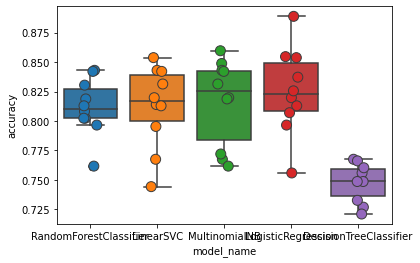

In [77]:
# Applying models

labels = df[1]
models = [
    RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', 
                           random_state = 0),
    LinearSVC(C=1.0, random_state=0),
    MultinomialNB(alpha=1, fit_prior=True),
    LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0),
    DecisionTreeClassifier(criterion='gini', 
                           max_features=None,min_samples_leaf=1, 
                           min_samples_split=2, random_state=0),
]

cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, linewidth=1)
plt.show()

In [78]:
# Printing the accuracies
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.747688
LinearSVC                 0.812386
LogisticRegression        0.825211
MultinomialNB             0.816449
RandomForestClassifier    0.811805
Name: accuracy, dtype: float64

In [21]:
features.shape

(1716, 489)

## Appyling other models

In [22]:
X = features
y = df.iloc[:, 1].values
indices = range(len(X))

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices,
                                                                                 test_size=0.2, random_state=42)

In [24]:
# Function to show original category vs predicted category

def show_prediction(y_pred, y_test):

    indices_match = y_pred == y_test

    df = pd.read_csv('Data/final_data.csv', header=None)

    get_comments = []

    for i in range(len(indices_test)):
        get_comments.append(df[0][indices_test[i]])


    data = list(zip(get_comments, y_test, y_pred))
    df_result = pd.DataFrame(data, columns=["comment", "original class", "predicted class"])
    return df_result

In [76]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB(alpha=1, fit_prior=True)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8372093023255814


In [26]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import MultinomialNB

# define models and parameters
model = MultinomialNB()
fit_prior=[True, False]
alpha=[0,0.5,1]

# define grid search
grid = dict(fit_prior=fit_prior,alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.827982 using {'alpha': 1, 'fit_prior': True}
0.788857 (0.035145) with: {'alpha': 0, 'fit_prior': True}
0.764336 (0.038807) with: {'alpha': 0, 'fit_prior': False}
0.823853 (0.028799) with: {'alpha': 0.5, 'fit_prior': True}
0.794958 (0.032420) with: {'alpha': 0.5, 'fit_prior': False}
0.827982 (0.027379) with: {'alpha': 1, 'fit_prior': True}
0.799087 (0.029267) with: {'alpha': 1, 'fit_prior': False}


In [27]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,not good its not the video lecture that you w...,negative,positive
1,Hello from India. I'm a student of class 10 an...,miscellaneous,miscellaneous
2,sir from where you are?,interrogative,interrogative
3,"Plz plz plz make video on bucket, radix and co...",positive,imperative
4,GODSEND!,positive,positive
...,...,...,...
339,what is the purpose of writing main function,interrogative,interrogative
340,51:14...........,miscellaneous,positive
341,The way of explanation was very nice.. Keep i...,positive,positive
342,hi tnx for such amazing as this tutorial . an...,interrogative,interrogative


In [74]:
# Linear SVC
from sklearn.svm import SVC

classifier = SVC(C=1.0, gamma='scale', kernel='linear', random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8168604651162791


In [29]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define model and parameters
model = SVC()
kernel = ['linear','poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.811966 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
0.765082 (0.028212) with: {'C': 50, 'gamma': 'scale', 'kernel': 'linear'}
0.690014 (0.024327) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.762171 (0.026900) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.751215 (0.035259) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.770181 (0.032027) with: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.655277 (0.027840) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.772857 (0.027702) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.802738 (0.030784) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.811966 (0.028433) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
0.568772 (0.023922) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.773825 (0.025085) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.800289 (0.026330) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.783295 (0.025080) with: {'C': 0.1, 'gamma': 'sca

In [30]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,not good its not the video lecture that you w...,negative,negative
1,Hello from India. I'm a student of class 10 an...,miscellaneous,miscellaneous
2,sir from where you are?,interrogative,interrogative
3,"Plz plz plz make video on bucket, radix and co...",positive,imperative
4,GODSEND!,positive,positive
...,...,...,...
339,what is the purpose of writing main function,interrogative,interrogative
340,51:14...........,miscellaneous,positive
341,The way of explanation was very nice.. Keep i...,positive,positive
342,hi tnx for such amazing as this tutorial . an...,interrogative,interrogative


In [31]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8343023255813954


In [32]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.829463 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.799088 (0.026352) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.804427 (0.026089) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.804670 (0.025558) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.806855 (0.025878) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.787903 (0.021944) with: {'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}
0.813907 (0.027932) with: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'none', 'solver': 'li

In [33]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,not good its not the video lecture that you w...,negative,negative
1,Hello from India. I'm a student of class 10 an...,miscellaneous,miscellaneous
2,sir from where you are?,interrogative,interrogative
3,"Plz plz plz make video on bucket, radix and co...",positive,imperative
4,GODSEND!,positive,positive
...,...,...,...
339,what is the purpose of writing main function,interrogative,interrogative
340,51:14...........,miscellaneous,positive
341,The way of explanation was very nice.. Keep i...,positive,positive
342,hi tnx for such amazing as this tutorial . an...,interrogative,interrogative


In [34]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.563953488372093


In [35]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_knn = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6104651162790697


In [36]:
# Kernal SVC RBF

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_k_svc = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7906976744186046


In [37]:
# Kernal SVC sigmoid

classifier = SVC(kernel = 'sigmoid', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8052325581395349


In [73]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier = RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', random_state = 0)

classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8459302325581395


In [39]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
criterion = ['gini', 'entropy']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,criterion=criterion)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.821690 using {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 1000}
0.785742 (0.028296) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
0.809059 (0.025252) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
0.808329 (0.024875) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000}
0.791555 (0.027647) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10}
0.817079 (0.024950) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
0.818047 (0.022121) with: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}
0.792301 (0.025825) with: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10}
0.807114 (0.023452) with: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}
0.806388 (0.023293) with: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 1000}
0.782572 (0.025591) with: {'criterion': 'entropy', 'max_featur

In [40]:
# # Show falsely predicted comments

# def show_neg_prediction(y_pred, y_test):

#     indices_match = y_pred == y_test

#     df = pd.read_csv('Scrapper/final.csv', header=None)

#     get_comments = []

#     for i in range(len(indices_test)):
#         if indices_match[i] == False:
#             get_comments.append(df[0][indices_test[i]])


#     data = list(zip(get_comments, y_test, y_pred))
#     df_result = pd.DataFrame(data, columns = ["comment", "original class", "predicted class"])
#     return df_result

In [41]:
df_ = show_prediction(y_pred, y_test)
pd.options.display.max_colwidth = 150
df_.iloc[200:250]


,comment,original class,predicted class
200,"hi, how to do this environment setting on windows 10",interrogative,interrogative
201,"Thank you sooo much , sir!",positive,positive
202,God has manifested to me in your form. Thank you.,positive,positive
203,thank you sir helped alot.....,positive,positive
204,javac is not working,negative,negative
205,can we find grammar mistakes from a sentence using nltk? please assist with an example,interrogative,interrogative
206,thanks for shearing knowledge thanks https://www.youtube.com/watch?v=gS2DNJ2-wJM&t=8s this is new program,positive,positive
207,@naresh i technologies plzz provide part 2 continuation and part 3 is missing plzz respond for or reply,imperative,miscellaneous
208,Please can you upload a lecture for midpoint circle and elipse algorithm in Graphics,interrogative,imperative
209,"Sir ,one important question is it necessary to write an algorithm for every problems can we find direct solution for every problem in exam and write",interrogative,interrogative


In [80]:
# Decision Tree
# from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_features=None,min_samples_leaf=1, 
                                    min_samples_split=2, random_state=0)
# classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7819767441860465


[Text(302.9011756106475, 216.5632258064516, 'X[206] <= 0.5\ngini = 0.742\nsamples = 1372\nvalue = [35, 215, 324, 123, 125, 550]'),
 Text(283.8168816138482, 214.80967741935484, 'X[304] <= 0.5\ngini = 0.714\nsamples = 1203\nvalue = [18, 215, 199, 96, 125, 550]'),
 Text(270.4863340107538, 213.05612903225807, 'X[55] <= 0.5\ngini = 0.679\nsamples = 1064\nvalue = [16, 115, 173, 96, 120, 544]'),
 Text(259.32923853876525, 211.3025806451613, 'X[280] <= 0.5\ngini = 0.648\nsamples = 986\nvalue = [15, 104, 112, 91, 120, 544]'),
 Text(250.3041902241025, 209.54903225806453, 'X[404] <= 0.5\ngini = 0.621\nsamples = 938\nvalue = [9, 104, 112, 88, 81, 544]'),
 Text(243.01197096136488, 207.79548387096773, 'X[461] <= 0.5\ngini = 0.682\nsamples = 779\nvalue = [9, 100, 110, 85, 78, 397]'),
 Text(238.55259348679584, 206.04193548387096, 'X[306] <= 0.5\ngini = 0.668\nsamples = 753\nvalue = [8, 100, 86, 84, 78, 397]'),
 Text(233.4307364317476, 204.2883870967742, 'X[189] <= 0.5\ngini = 0.654\nsamples = 729\nvalu

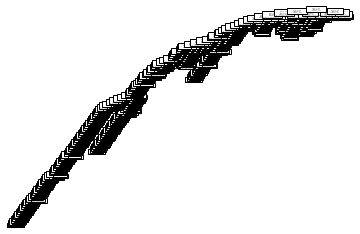

In [82]:
# from sklearn import tree
# tree.export_graphviz(classifier, out_file='tree.dot') 
tree.plot_tree(classifier) 

In [43]:
### Hyperparameter Tuning ###

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = DecisionTreeClassifier()
max_features = ['sqrt', 'log2', 'auto']
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
min_samples_split = range(1,10)
min_samples_leaf = range(1,5)
# define grid search
grid = dict(max_depth=max_depth,max_features=max_features,criterion=criterion,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.623160 using {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1}
0.454581 (0.046607) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.461642 (0.032164) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3}
0.451430 (0.039164) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4}
0.442408 (0.025815) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
0.437560 (0.027838) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6}
0.455326 (0.042358) with: {'criterion': 'gini', 'max_depth'

In [44]:
show_prediction(y_pred, y_test)

,comment,original class,predicted class
0,not good its not the video lecture that you want...,negative,negative
1,Hello from India. I'm a student of class 10 and lerarning JAVA programming from your channel.,miscellaneous,miscellaneous
2,sir from where you are?,interrogative,positive
3,"Plz plz plz make video on bucket, radix and count sorts as well, they're nowhere on youtube",positive,imperative
4,GODSEND!,positive,miscellaneous
...,...,...,...
339,what is the purpose of writing main function,interrogative,interrogative
340,51:14...........,miscellaneous,miscellaneous
341,The way of explanation was very nice.. Keep it up.,positive,positive
342,hi tnx for such amazing as this tutorial . and i have question i set as Environment Variables and it doesn't show me in command prompt could u te...,interrogative,interrogative


## Plotting accuracy vs data size

In [ ]:
def plot_acc_curve(classifier, linestyle, label):    
    
    num_of_splits = 14
    each_split_size = len(X_train)//num_of_splits

    each_split = 98
    scores = []

    for i in range(num_of_splits+1):
        split_X_train = X_train[0:each_split]
        split_y_train = y_train[0:each_split]

        each_split += each_split_size

        classifier.fit(split_X_train, split_y_train)
        scores.append(classifier.score(X_test, y_test))
    
    m = 14
    n = 98
    x_splits = list(range(0, (m+1)*n, n))

    plt.xlabel('data_size')
    plt.ylabel('accuracy')
    plt.plot(x_splits, scores, linestyle, label = label)
    plt.xticks(x_splits)
    plt.legend(loc="best")
    
    return plt
    

plt.figure(figsize=(12,8))

# Linear SVC
classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 0.1)
plot_acc_curve(classifier, linestyle = 'o-', label="Linear SVC")

# Logistic Regression
classifier = LogisticRegression(random_state = 0)
plot_acc_curve(classifier, linestyle = '*-', label="Logistic Regression")

# Multinomial NB
classifier = MultinomialNB()
plot_acc_curve(classifier, linestyle = '^-', label="Multinomial NB")

# Random Forest Classifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
plot_acc_curve(classifier, linestyle = 's-', label="Random Forest Classifier")

# Decision Tree Classifier
classifier = DecisionTreeClassifier()
plot_acc_curve(classifier, linestyle = 'x-', label="Decision Tree Classifier")

plt.show()

## PLotting the learning curves

In [ ]:


# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))

#     axes[0].set_title(title)
#     if ylim is not None:
#         axes[0].set_ylim(*ylim)
#     axes[0].set_xlabel("Training examples")
#     axes[0].set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes,
#                        return_times=True)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

#     # Plot learning curve
#     axes[0].grid()
#     axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes[0].legend(loc="best")

#     # Plot n_samples vs fit_times
#     axes[1].grid()
#     axes[1].plot(train_sizes, fit_times_mean, 'o-')
#     axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
#                          fit_times_mean + fit_times_std, alpha=0.1)
#     axes[1].set_xlabel("Training examples")
#     axes[1].set_ylabel("fit_times")
#     axes[1].set_title("Scalability of the model")

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

#     return plt


# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# # X, y = load_digits(return_X_y=True)

# title = "Learning Curves (Naive Bayes)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)

# title = r"Learning Curves (SVM, linear, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = LogisticRegression(random_state = 0)
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)

# plt.show()

## Creating a json file and sending to the server

In [ ]:
# cm_rf_p = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
# cm_lr_p = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
# cm_knn_p = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
# cm_k_svc_p = cm_k_svc.astype('float') / cm_k_svc.sum(axis=1)[:, np.newaxis]
# cm_dt_p = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

In [ ]:
# unique, counts = np.unique(y_pred, return_counts=True)

In [ ]:
# dict_pred_rf = dict(zip(unique, cm_rf_p.diagonal()))
# dict_pred_lr = dict(zip(unique, cm_lr_p.diagonal()))
# dict_pred_knn = dict(zip(unique, cm_knn_p.diagonal()))
# dict_pred_k_svc = dict(zip(unique, cm_k_svc_p.diagonal()))
# dict_pred_dt = dict(zip(unique, cm_dt_p.diagonal()))

In [ ]:
# import json

# models = ['random_forest', 'linear_regression', 'knn', 'kernal_svc', 'decision_tree']
# pred_dict = [dict_pred_rf, dict_pred_lr, dict_pred_knn, dict_pred_k_svc, dict_pred_dt]

# predictions = {}
# for model, pred in zip(models, pred_dict):
#     predictions[model] = pred

# with open('prediction.json', 'w') as json_file:
#     json.dump(predictions, json_file)

In [ ]:
# predictions

In [ ]:
# To DO:
# Send json